/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_40177/2730965396.py:55: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  idx = torch.bucketize(x, knots)


Step 0, negative log-lik 15.2968
Step 20, negative log-lik 12.5771
Step 40, negative log-lik 12.0240
Step 60, negative log-lik 11.8155
Step 80, negative log-lik 11.6976


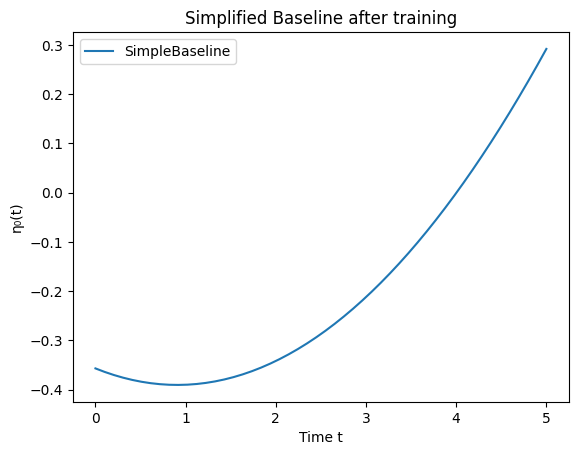

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

############################################
# 1) Simple B-spline baseline
############################################

def simple_polynomial_basis(t, degree=3):
    """
    A simplified polynomial basis for demonstration (like a 'fake' B-spline).
    For real usage, replace with a true B-spline library.
    Input:
      t: shape [N]
    Output:
      B: shape [N, degree+1] (columns are 1, t, t^2, t^3)
    """
    # We'll do powers up to `degree`
    B_list = []
    for p in range(degree + 1):
        B_list.append(t**p)
    B = torch.stack(B_list, dim=1)
    return B

class SimpleBaseline(nn.Module):
    """
    A simplified version of a B-spline baseline: \eta_0(t) = sum_k coefs_k * basis_k(t)
    We'll use a polynomial basis for demonstration.
    """
    def __init__(self, degree=3):
        super().__init__()
        self.degree = degree
        # We'll have (degree+1) coefficients to learn
        self.coefs = nn.Parameter(torch.zeros(degree+1))
    
    def forward(self, t):
        # t: shape [batch_size]
        B = simple_polynomial_basis(t, degree=self.degree)
        eta_t = B.matmul(self.coefs)  # (batch_size,)
        return eta_t

############################################
# 2) Single-Layer "KAN" with Summation of 1D Splines
############################################

def piecewise_linear_spline_1d(x, knots, params):
    """
    A piecewise-linear spline in 1D:
      - knots: shape [num_knots]
      - params: shape [num_knots], the spline values at these knots
    We find which sub-interval x is in, and linearly interpolate.
    """
    # Bucketize x
    idx = torch.bucketize(x, knots)
    # clamp index so it's in [1, num_knots-1]
    idx = torch.clamp(idx, 1, knots.shape[0]-1)

    x_lower = knots[idx-1]
    x_upper = knots[idx]
    y_lower = params[idx-1]
    y_upper = params[idx]

    # fractional weight in [0,1]
    denom = (x_upper - x_lower).clamp_min(1e-8)
    alpha = (x - x_lower) / denom

    return y_lower + alpha*(y_upper - y_lower)

class SimpleUnivariateSpline(nn.Module):
    """
    A univariate piecewise-linear spline. 
    For interpretability, the user can visualize 'spline_params' vs. 'knots'.
    """
    def __init__(self, num_knots=5, x_range=(0.,1.)):
        super().__init__()
        self.num_knots = num_knots
        # Register buffer for the knot locations
        self.register_buffer('knots', torch.linspace(x_range[0], x_range[1], steps=num_knots))
        # Make the spline values at each knot learnable
        self.params = nn.Parameter(torch.zeros(num_knots))

    def forward(self, x):
        """
        x: shape [batch_size]
        return: shape [batch_size] (the univariate transform)
        """
        return piecewise_linear_spline_1d(x, self.knots, self.params)

class SimpleKANSingleLayer(nn.Module):
    """
    Summation across input dimension. If input dimension = d_x, we have d_x univariate 
    splines, each transforming one coordinate of x, then summing them for the final output.
    f(x) = sum_{v=1 to d_x} Spline_v(x_v).
    """
    def __init__(self, d_x=3, num_knots=5, x_range=(0.,1.)):
        super().__init__()
        self.d_x = d_x
        # Create one univariate spline per dimension
        self.splines = nn.ModuleList([
            SimpleUnivariateSpline(num_knots, x_range) for _ in range(d_x)
        ])
    
    def forward(self, x):
        """
        x: shape [batch_size, d_x]
        Output is shape [batch_size] (just one scalar per row).
        """
        # sum of each dimension's univariate transform
        # We'll do a for loop for clarity.
        out = torch.zeros(x.shape[0], device=x.device)
        for v in range(self.d_x):
            out += self.splines[v](x[:, v])
        return out

############################################
# 3) IPP Model: lambda(t) = exp(baseline(t) + f(x))
############################################

class SimpleInhomPP(nn.Module):
    def __init__(self, d_x=3, poly_degree=3, num_knots=5):
        super().__init__()
        self.baseline = SimpleBaseline(degree=poly_degree)
        self.fKAN = SimpleKANSingleLayer(d_x=d_x, num_knots=num_knots, x_range=(0,1))

    def forward(self, t, x):
        """
        Returns log-lambda(t, x) for convenience.
        """
        log_intensity = self.baseline(t) + self.fKAN(x)
        return log_intensity

    def intensity(self, t, x):
        return torch.exp(self.forward(t, x))

############################################
# 4) Likelihood & Example Training
############################################

def compute_loglik_simplified(model, events_list, censor_list, integration_pts=10):
    """
    events_list: List of lists, for each subject, a series of (t_event, x_event).
    censor_list: List of (c_time, x_censor).
    """
    total_loglik = 0.0
    device = next(model.parameters()).device

    for i, evs in enumerate(events_list):
        # sum_{j=1..n_i} log(lambda(t_j, x_j))
        if len(evs) > 0:
            tvals = torch.tensor([e[0] for e in evs], dtype=torch.float32, device=device)
            xvals = torch.stack([e[1] for e in evs], dim=0).to(device)
            log_ints = model.forward(tvals, xvals)
            event_term = log_ints.sum()
        else:
            event_term = 0.0

        # - \int_0^{c_i} lambda(t, x_i) dt
        cend, x_c = censor_list[i]
        t_grid = torch.linspace(0, cend, steps=integration_pts, device=device)
        x_grid = x_c.unsqueeze(0).repeat(integration_pts, 1).to(device)
        lam_vals = model.intensity(t_grid, x_grid)  # shape [integration_pts]
        integral_approx = torch.trapz(lam_vals, t_grid)
        subject_loglik = event_term - integral_approx
        total_loglik += subject_loglik
    return total_loglik

def main_simplified():
    # Model hyperparams
    d_x = 3
    poly_degree = 2
    num_knots = 5
    
    model = SimpleInhomPP(d_x=d_x, poly_degree=poly_degree, num_knots=num_knots)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Dummy data
    # Suppose 5 subjects, random censor times in [2,5]
    # each subject has 0-3 events
    events_list = []
    censor_list = []
    for _ in range(5):
        c_i = float(torch.rand(1)*3 + 2.0)  # in [2,5]
        n_events = torch.randint(0,4,(1,)).item()
        t_e = torch.sort(torch.rand(n_events)*c_i)[0]
        # random x in [0,1]^d_x
        # assume x constant for the subject
        x_subj = torch.rand(d_x)
        evs = [(float(t_e[j]), x_subj) for j in range(n_events)]
        events_list.append(evs)
        censor_list.append((c_i, x_subj))

    # Training
    for step in range(100):
        optimizer.zero_grad()
        loglik = compute_loglik_simplified(model, events_list, censor_list, integration_pts=10)
        loss = -loglik
        loss.backward()
        optimizer.step()
        if step % 20 == 0:
            print(f"Step {step}, negative log-lik {loss.item():.4f}")

    # Inspect baseline
    model.eval()
    t_plot = torch.linspace(0,5, steps=50)
    with torch.no_grad():
        baseline_vals = model.baseline(t_plot)
    plt.plot(t_plot.numpy(), baseline_vals.numpy(), label='SimpleBaseline')
    plt.xlabel('Time t')
    plt.ylabel('η₀(t)')
    plt.title('Simplified Baseline after training')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main_simplified()
